<nbsp>

<nbsp>

<font size = 6> <center> <b> Deep Convolutional Generative Advarsarial Networks </b> </center> <font>

</nbsp>

<font size = 5> <center> <b> (oh, and also Image Completion) </b> </center> <font>

<b><font size =6> The Team</font></b>

<b><font size = 2> Prof. Peter Belhumeur </font> </b>

<left> <img src='images/pb.png'> </left>

<b><font size = 2> Aashima Arora (aa3917)</font> </b>

<left> <img src='images/aashima.jpg'> </left>

<b><font size = 2> Nishant Puri (np2577) </font> </b>

<left> <img src='images/nishant.jpg'> </left>

<b><font size = 2> Siddharth Bhatnagar (sb3882)</font><b>

<left> <img src='images/sid.jpg'> </left>

<b><font size =6> Objective</font></b>

1. Generate Samples from a High Dimensional Distribution using DCGANs 
2. Show the robustness of our model by making sure it doesn’t memorize the training set
3. Perform Image Completion using the above model to fill in the incomplete parts of our images

<b><font size =6> Theory</font></b>

## Why study generative modelling?

One might legitimately wonder why generative models are worth studying, especially generative models that are only capable of generating data rather than providing an estimate of the density function. After all, when applied to images, such models seem to merely provide more images, and the world has no shortage of images. 
There are several reasons to study generative models, including: 

* Training and sampling from generative models is an excellent test of our ability to represent and manipulate high-dimensional probability distributions. High-dimensional probability distributions are important objects in a wide variety of applied math and engineering domains. 
* 	Generative models can be incorporated into reinforcement learning in several ways. 
*	Generative models can be trained with missing data and can provide predictions on inputs that are missing data. 

One particularly interesting case of missing data is semi-supervised learning, in which the labels for many or even most training examples are missing. Modern deep learning algorithms typically require extremely many labeled examples to be able to generalize well. Semi-supervised learning is one strategy for reducing the number of labels. The learning algorithm can improve its generalization by studying a large number of unlabeled examples which, which are usually easier to obtain. Generative models, and GANs in particular, are able to perform semi-supervised learning reasonably well. 


<b><font size =6> Dataset</font></b>

<b> Flowers: 102 Category Flower Dataset, Visual Geometry Group, University of Oxford</b>

http://www.robots.ox.ac.uk/~vgg/data/flowers/102/

~8,000 images from 102 categories

After augmentation: https://www.dropbox.com/s/2n7qd2qq39hsmnw/jpg2.zip?dl=0


Some Samples
<img src='images/flower_training_set.jpg'>


<b>Large-scale CelebFaces Attributes (CelebA) Dataset, Multimedia Laboratory, The Chinese University of Hong Kong</b>

202,599 images of celebrity faces

http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html


<b>LFWcrop Face Dataset</b>: 

13,233 images of human faces

http://conradsanderson.id.au/lfwcrop/

Some samples:
<img src='images/faces_training_set.jpg'>

<b> Data Cleaning - augmentation, cropping, conversions</b>

In [ ]:
from PIL import Image
import glob, os, sys
import scipy.misc

for filename in glob.glob('/home/icarus/Documents/DCGAN_Tensorflow/FacesDataset/data/celebA/*'):
     image = scipy.misc.imread(filename)
     f, e = os.path.splitext(filename)
     outname = f + "_cropped" + e
     im2 = scipy.misc.imresize(image[55:163, 30:148], [64,64])
     scipy.misc.imsave(outname, im2)

In [ ]:
from PIL import Image
import glob, os, sys

count = 0

for filename in glob.glob('/home/icarus/Documents/DCGAN_Tensorflow/FacesDataset/faces/*'):
    f, e = os.path.splitext(filename)
    outfile = f + ".jpg"
    count += 1
    print outfile
    try:
        Image.open(filename).save(outfile)
    except IOError:
        print "cannot convert" + filename


print count

## The GAN Framework

The basic idea of GANs is to set up a game between two players. One of them is called the *generator*. The generator creates samples that are intended to come from the same distribution as the training data. The other player is the *discriminator*. The discriminator examines samples to determine whether they are real or fake. The discriminator learns using traditional supervised learning techniques, dividing inputs into two classes (real or fake). The generator is trained to fool the discriminator. We can think of the generator as being like a counterfeiter, trying to make fake money, and the discriminator as being like police, trying to allow legitimate money and catch counterfeit money. To succeed in this game, the counterfeiter must learn to make money that is indistinguishable from genuine money, and the generator network must learn to create samples that are drawn from the same distribution as the training data. 

## Cost functions 

The cost used for the discriminator is:

\begin{align*}
J^{(D)}(\theta^{(D)},\theta^{(G)} = -\frac{1}{2}E_{x \in p_{data}}logD(x) - \frac{1}{2}E_z log(1 - D(G(z)))
\end{align*}

This is just the standard cross-entropy cost that is minimized when training a standard binary classifier with a sigmoid output. The only difference is that the classifier is trained on two minibatches of data; one coming from the dataset, where the label is $1$ for all examples, and one coming from the generator, where the label is $0$ for all examples. We see that by training the discriminator, we are able to obtain an estimate of the ratio $\frac{pdata(x)}{ pmodel(x)}$ at every point $x$. Estimating this ratio enables us to compute a wide variety of divergences and their gradients. This is the key approximation technique that sets GANs apart from variational autoencoders and Boltzmann machines. The GAN approximation is subject to the failures of supervised learning: *overfitting and underfitting*. In principle, with perfect optimization and enough training data, these failures can be overcome. Other models make other approximations that have other failures. 

Because the GAN framework can naturally be analyzed with the tools of game theory, we call GANs “adversarial.” But we can also think of them as cooperative, in the sense that the discriminator estimates this ratio of densities and then freely shares this information with the generator. From this point of view, the discriminator is more like a teacher instructing the generator in how to improve than an adversary. So far, this cooperative view has not led to any particular change in the development of the mathematics. 

### Minimax Game


We train D to maximize the probability of assigning the correct label to both training examples and samples from G.


We simultaneously train G to minimize $log(1 − D(G(z)))$. In other words, D and G play the following two-player minimax game with value function V (G, D) :

\begin{align*}
min_{G}max_{D}V(D,G) = E_{x \in p_{data}(x)} logD(x) + E_{z \in p_{z}(z)}log(1 - D(G(z)) 
\end{align*}

Optimizing $D$ to completion in the inner loop of training is computationally prohibitive, and on finite datasets would result in overfitting. The training criterion allows one to recover the data generating distribution as $G$ and $D$ are given enough capacity, i.e., in the non-parametric limit. Instead, we alternate between $k$ steps of optimizing $D$ and one step of optimizing $G$. This results in D being maintained near its optimal solution, so long as $G$ changes slowly enough. 




## The DCGAN architecture 

Most GANs today are at based on the DCGAN architecture (Radford et al., 2015). DCGAN stands for “deep, convolution GAN.” Though GANs were both deep and convolutional prior to DCGANs, the name DCGAN is useful to refer to this specific style of architecture. Some of the key insights of the DCGAN architecture were to: 
+	Replace any pooling layers with *strided convolutions* (discriminator) and *fractional-strided convolutions* (generator). 
+	Use *batch normalization* layers in most layers of both the discriminator and the generator, with the two minibatches for the discriminator normalized separately. The last layer of the generator and first layer of the discriminator are not batch normalized, so that the model can learn the correct mean and scale of the data distribution. 
+	Remove fully connected hidden layers for deeper architectures. 
+	Use *ReLU* activation in generator for all layers except for the output, which uses Tanh. 
+	Use *LeakyReLU* activation in the discriminator for all layers. 
+	The use of the *Adam optimizer* rather than SGD with momentum. 




### Tensorflow

In [ ]:
#imports

import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time as ti
import csv
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from pympler import asizeof
import time as ti
from PIL import Image
import scipy.misc


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### Layers

In [ ]:
#layers
def lrelu(x,alpha=0.2):
    return tf.maximum(x, alpha*x)

def gaussian_noise_layer(input_tensor, std=0.2):
    noise = tf.random_normal(shape=tf.shape(input_tensor), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_tensor + noise

def linear(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        weights = tf.get_variable("weights", [input_dim, output_dim], initializer=tf.truncated_normal_initializer(stddev=math.sqrt(3.0 / (input_dim + output_dim))))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        return tf.matmul(input_tensor, weights) + bias 

def conv_2d(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5,input_dim, output_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_tensor, kernel, strides=[1, 2, 2, 1],padding='SAME')
        return conv+bias

def conv_2dtranspose(input_tensor, input_dim, output_shape,name=None):
    output_dim=output_shape[-1]
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5, output_dim, input_dim], initializer=tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        deconv = tf.nn.conv2d_transpose(input_tensor, kernel, output_shape=output_shape, strides=[1, 2, 2, 1],padding='SAME')
        return deconv+bias

def batch_norm(input_tensor,name,is_train=True):
    return tf.contrib.layers.batch_norm(input_tensor,decay=0.9, updates_collections=None, epsilon=1e-5, scale=True,    
                                        is_training=is_train, scope=name)

## Improvement 1 - Minibatch Discrimination

One of the main failure modes for GAN is for the generator to collapse to a parameter setting where it always emits the same point. When collapse to a single mode is imminent, the gradient of the discriminator may point in similar directions for many similar points. Because the discriminator processes each example independently, there is no coordination between its gradients, and thus no mechanism to tell the outputs of the generator to become more dissimilar to each other. Instead, all outputs race toward a single point that the discriminator currently believes is highly realistic. After collapse has occurred, the discriminator learns that this single point comes from the generator, but gradient descent is unable to separate the identical outputs. The gradients of the discriminator then push the single point produced by the generator around space forever, and the algorithm cannot converge to a distribution with the correct amount of entropy. An obvious strategy to avoid this type of failure is to allow the discriminator to look at multiple data examples in combination, and perform what we call minibatch discrimination. The concept of minibatch discrimination is quite general: any discriminator model that looks at multiple examples in combination, rather than in isolation, could potentially help avoid collapse of the generator. 


### Process

Let $f(x_i) \in R^A$ denote a vector of features for input $x_i$, produced by some intermediate layer in the discriminator. We then multiply the vector $f(x_i)$ by a tensor $T \in R^A \times R^B x R^C$, which results in a matrix $M_i \in R^BxR^C$. We then compute the $L1$-distance between the rows of the resulting matrix $M_i$ across samples $i \in {1,2,...,n}$
and apply a negative exponential $c_b (x_i , x_j ) = exp(−|| M_{i,b}− M_{j,b} || _{L1})$. The output $o(x_i)$ for this minibatch layer for a sample $x_i$ is then defined as the sum of the $c_b(x_i,x_j)$’s to all other samples:

\begin{align}
o(x_i)b =  \sum_{j=1}^n c_b(x_i,x_j) \in \mathbb{R} \\
o(x_i)= [o(x_i)_1 ,o(x_i)_2 ,...,o(x_i)_B]  \in \mathbb{R}^B \\
o(X) \in \mathbb{R}^{n \times B} \\
\end{align}

*In other words*,

+ Allow $D$ to look at multiple images in the same minibatch.
+ Feed the features (of each image) extracted by an intermediate layer of $D$ through a linear operation, resulting in a matrix per image.
+ Compute the $L1$ distances between these matrices.
+ Let $D$ make its judgement (fake/real image) based on the features extracted from the image and these distances.
+ Add this mechanism so that the diversity of images generated by $G$ increases (which should also prevent collapses).

In [ ]:
def minibatch_discrimination(input_tensor, name, num_kernels=100, kernel_dim=5):
    with tf.variable_scope(name) as scope:
        input_shape = input_tensor.get_shape().as_list()
        print "input-shape" , input_shape
        features = input_shape[1]
        print features
        W = tf.get_variable("weight", [features, num_kernels * kernel_dim], initializer=tf.contrib.layers.xavier_initializer())
        bias = tf.get_variable("bias", [num_kernels], initializer=tf.constant_initializer(0.0))
        activation = tf.matmul(input_tensor,W)
        print activation.get_shape()
        activation = tf.reshape(activation,[-1,num_kernels,kernel_dim])
        a1 = tf.expand_dims(activation, 3)
        a2 = tf.transpose(activation, perm=[1,2,0])
        a2 = tf.expand_dims(a2, 0)
        abs_diff = tf.reduce_sum(tf.abs(a1 - a2), reduction_indices=[2])
        expsum  = tf.reduce_sum(tf.exp(-abs_diff), reduction_indices=[2])
        expsum = expsum + bias
        print expsum.get_shape()
        return tf.concat([input_tensor,expsum],axis=1)

<img src='images/generator_architecture.jpg'>

In [ ]:
def generator(z):
    l1=linear(input_tensor=z,name="gen_lin", input_dim=100, output_dim=1024*4*4)  
    l2= tf.reshape(l1, [-1, 4, 4, 1024])
    l3 = lrelu(batch_norm(input_tensor=l2,name="gen_bn0"))
    print l3
    #conv1
    l4=conv_2dtranspose(input_tensor=l3,name="gen_c2dt1",input_dim=1024,output_shape=[batch_size,8,8,512])
    l5=lrelu(batch_norm(input_tensor=l4,name="gen_bn1"))
    print l5
    #conv2
    l6=conv_2dtranspose(input_tensor=l5,name="gen_c2dt2",input_dim=512,output_shape=[batch_size,16,16,256])
    l7=lrelu(batch_norm(input_tensor=l6,name='gen_bn2'))
    print l7
    #conv3
    l8=conv_2dtranspose(input_tensor=l7,name='gen_c2dt3',input_dim=256,output_shape=[batch_size,32,32,128])
    l9=lrelu(batch_norm(input_tensor=l8,name='gen_bn3'))
    print l9
    #conv4
    l10=conv_2dtranspose(input_tensor=l9,name='gen_c2dt4',input_dim=128,output_shape=[batch_size,64,64,3])
    l11=tf.nn.tanh(l10)
    print l11
    return l11

<img src='images/discrim_arch.jpg'>

## Improvement 2 - Instance Noise

+ A major reason for GANs' instability may be that the generative distributions are weird, degenerate, and their support don't generally overlap with the true data distribution.
+ This makes the nice theory break down and may lead to unstable behavior.
+ Adding noise to both real and synthetic data during training might help overcome these problems

In an idealised GAN algorithm, each iteration consisting of the following steps 

1. We train the discriminator $D$ via logistic regression between our generative model $q_\theta$ vs true data $p$ until convergence
2. We extract from $D$ an estimate of the logarithmic likelihood ratio $s(y)=\frac{logq_\theta(y)}{p(y)}$
3. We update $\theta$ by taking a stochastic gradient step with objective function $E_y \in q_\theta(y)$

But there are problems in convergence due to the following assumptions,

1. that the log-likelihood-ratio $s(y)=\frac{logq_\theta(y)}{p(y)}$ is finite, or 
2. that the Jensen-Shannon divergence $JS[q_\theta‖p]$ is a well-behaved function of \theta and 
3. that the Bayes-optimal solution to the logistic regression problem is unique: there is a single optimal discriminator that does a much better job than any other classifier.

But any of the following might not be true especially that there may be a large set of near-optimal discriminators whose loss is very close to the Bayes optimum. Thus, for a fixed $q_\theta$ and $p$, training the discriminator $D$
might lead to a different near-optimal solution each time depending on initialisation. And, each of these near-optimal solutions might provide very different gradients (or no useful gradients at all) to the generator.

We add gaussian additive noise to the layer of the discriminator. We add noise to samples from both $q_\theta$ and $p$
The noisy distributions now overlap, the log-likelihood-ratio is well-behaved, and the JS divergence between the two noisy distributions is a non-constant function of $\theta$.




In [ ]:
def discriminator(images, reuse=False, alpha=0.2):
     with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
            
        images = gaussian_noise_layer(images)
        #naming of the layers is as per layer number    
        #h0 conv2d no batch_norm
        l1 = conv_2d(input_tensor=images, input_dim=3, output_dim= 64, name='discrim_c2d0')
        l2 = lrelu(l1,alpha)

        #h1 conv2d with batch_norm
        l3 = conv_2d(input_tensor=l2, input_dim=64, output_dim=64*2, name='discrim_c2d1')
        l4 = batch_norm(input_tensor=l3,name="discrim_bn1")
        l5 = lrelu(l4,alpha)

        #h2 conv2d with batch_norm
        l6 = conv_2d(input_tensor=l5, input_dim=64*2, output_dim=64*4, name='discrim_c2d2')
        l7 = batch_norm(input_tensor=l6,name="discrim_bn2")
        l8 = lrelu(l7,alpha)

        #h3 conv2d with batch_norm
        l9 = conv_2d(input_tensor=l8, input_dim=64*4, output_dim=64*8, name='discrim_c2d3')
        l10 = batch_norm(input_tensor=l9,name="discrim_bn3")
        l11 = lrelu(l10,alpha)

        #h4 reshape and linear
        #minibatch discrimination layer
        l12 = tf.reshape(l11, [-1, 8192]) #l12 = tf.reshape(l11, [32, -1]) #l12 = tf.reshape(l11, [64, -1])
        l13 = minibatch_discrimination(l12,name="discrim_mini",num_kernels=100)
        print l13.get_shape()
        input_dim_linear = l13.get_shape().as_list()
        l14 = linear(input_tensor=l13, input_dim=input_dim_linear[1], output_dim=1, name="discrim_lin4")
        print l14.get_shape().as_list()
        #sigmoid

        l15 = tf.nn.sigmoid(l14)
        print l15
        return l15, l14

In [ ]:
#place holders for images and z
#z = tf.placeholder(tf.float32,name='z')
z = tf.placeholder(tf.float32, [None, 100], name='z')
G=generator(z)
#placeholder for images
images = tf.placeholder(tf.float32, [None,64,64,3], name='images')
alpha = 0.2
D1, D1_logits = discriminator(images, False, alpha)
D2, D2_logits = discriminator(G, True, alpha)

#cretae list of discrim and gen vars
t_vars=tf.trainable_variables()
for var in t_vars:
    print var.name
discrim_vars=[]
gen_vars=[]
for var in tf.trainable_variables():
    if 'discrim_' in var.name:
        discrim_vars.append(var)
    if 'gen_' in var.name:
        gen_vars.append(var)

In [ ]:
img_width, img_height = 64, 64
data_dir = './final_face_data'
learning_rate= 0.0002
beta1= 0.5
batch_size=64

## Improvement 3 - One Sided Label Smoothing

GANs are intended to work when the discriminator estimates a ratio of two densities, but deep neural nets are prone to producing highly confident outputs that identify the correct class but with too extreme of a probability. This is especially the case when the input to the deep network is adversarially constructed the classifier tends to linearly extrapolate and produce extremely confident predictions. 

To encourage the discriminator to estimate soft probabilities rather than to extrapolate to extremely confident classification, we can use a technique called *one-sided label smoothing .*

The idea of one-sided label smoothing is to replace the target for the real examples with a value slightly less than one, such as $.9$. This prevents extreme extrapolation behavior in the discriminator; if it learns to predict extremely large logits corresponding to a probability approaching $1$ for some input, it will be penalized and encouraged to bring the logits back down to a smaller value.  It is important to not smooth the labels for the fake samples. Suppose we use a target of $1− \alpha$ for the real data and a target of $0+\beta$ for the fake samples. Then the optimal discriminator function is 

\begin{align}
    D^*(x) = \frac{(1 − \alpha)p_{data}(x) + \beta p_{model}(x)}{p_{data}(x) + p_{model}(x)}$
\end{align}

When $\beta$ is zero, then smoothing by $\alpha$ does nothing but scale down the optimal value of the discriminator. When $\beta$ is nonzero, the shape of the optimal discriminator function changes. In particular, in a region where $p_{data}(x)$ is very small and $p_{model}(x)$ is larger, $D^*(x)$ will have a peak near the spurious mode of $p_{model}(x)$. The discriminator will thus reinforce incorrect behavior in the generator; the generator will be trained either to produce samples that resemble the data or to produce samples that resemble the samples it already makes. 
Label smoothing is an excellent regularizer in the context of convolutional networks for object recognition. One reason that label smoothing works so well as a regularizer is that it does not ever encourage the model to choose an incorrect class on the training set, but only to reduce the confidence in the correct class. Other regularizers such as weight decay often encourage some misclassification if the coefficient on the regularizer is set high enough. *Warde-Farley and Goodfellow (2016)* showed that label smoothing can help to reduce vulnerability to adversarial examples, which suggests that label smoothing should help the discriminator more efficiently learn to resist attack by the generator. 




In [ ]:
#LOSS
discrim_loss_real_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D1_logits, labels=tf.scalar_mul(0.9,tf.ones_like(D1_logits))))
discrim_loss_fake_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, labels=tf.zeros_like(D2_logits)))
discrim_loss = discrim_loss_real_img + discrim_loss_fake_img
gen_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, labels=tf.ones_like(D2_logits)))

#optimizers
dopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(discrim_loss, var_list=discrim_vars)
gopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(gen_loss, var_list=gen_vars)

In [ ]:
def show_sample(X):
    im = X
    plt.imshow(im)
    plt.axis('on')
    plt.show()  

def merge_images(image_batch, size):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im
    return img

def save_image(X, iter, fl):
    #im = Image.fromarray(X)
    name = 'Iteration' + str(iter) + 'time' + str(ti.time()) + '.png'
    #im.save(name)
    if (fl == False):
        name = 'Random'+name
    size = [8,8]
    #change X back
    X[0] = (X[0] + 1.)/2

    im = merge_images(X[0], size)
    scipy.misc.imsave(name, im)

def save_sample(X, iter, fl):
    im = X
    plt.imshow(im)
    plt.axis('on')
    #plt.show()
    name = 'Iteration' + str(iter) + 'time' + str(ti.time()) + '.png'
    plt.savefig(name)

def preprocessing(image):
    return image/127.5 - 1;

load_img_datagen = ImageDataGenerator(preprocessing_function = preprocessing)
img_input = load_img_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None)

## Training Process

The training process consists of simultaneous $SGD$. On each step, two minibatches are sampled: a minibatch of x values from the dataset and a minibatch of z values drawn from the model’s prior over latent variables. Then two gradient steps are made simultaneously: one updating $\theta{(D)}$ to reduce $J(D)$ and one updating $\theta{(G)}$ to reduce $J(G)$. In both cases, it is possible to use the gradient-based optimization algorithm of your choice. Adam (Kingma and Ba, 2014) is usually a good choice. Many authors recommend running more steps of one player than the other, but as of late 2016, the author’s opinion is that the protocol that works the best in practice is simultaneous gradient descent, with one step for each player. 


1. $G$ is a simple neural net (e.g. just one fully connected hidden layer). It takes a vector as input (e.g. 100 dimensions) and produces an image as output.
2.	$D$ is a simple neural net (e.g. just one fully connected hidden layer). It takes an image as input and produces a quality rating as output (0-1, so sigmoid).
3.	You need a training set of things to be generated, e.g. images of human faces.
4.	Let the batch size be B.
5.	$G$ is trained the following way:
    + Create B vectors of 100 random values each, e.g. sampled uniformly from $[-1, +1]$. (Number of values per components depends on the chosen input size of G.)
    +	Feed forward the vectors through $G$ to create new images.
    +	Feed forward the images through $D$ to create ratings.
    +	Use a cross entropy loss on these ratings. All of these (fake) images should be viewed as $label = 0$ by $D$. If $D$ gives them $label=1$, the error will be low ($G$ did a good job).
    +	Perform a backward pass of the errors through $D$ (without training $D$). That generates gradients/errors per image and pixel.
    +	Perform a backward pass of these errors through $G$ to train $G$.
6.	$D$ is trained the following way:
    +	Create B/2 images using $G$ (again, B/2 random vectors, feed forward through G).
    +	Chose B/2 images from the training set. Real images get $label=1$.
    +	Merge the fake and real images to one batch. Fake images get $label=0$.
    +	Feed forward the batch through $D$.
    +	Measure the error using cross entropy.
    +	Perform a backward pass with the error through $D$.
7.	Train $G$ for one batch, then $D$ for one (or more) batches. Sometimes $D$ can be too slow to catch up with $D$, then you need more iterations of $D$ per batch of $G$.

<img src='images/training_proced.png'>

In [ ]:
sess = tf.Session()
#sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

d_loss_all=[]
g_loss_all=[]

disp_img_noise = np.random.uniform(-1,1,size=[batch_size,100])
saver = tf.train.Saver()
f = open('train.log', 'w+')
iters = 50000

for i in range(iters):
    #train discriminator
    real_images=next(img_input)
    noise= np.random.uniform(-1,1,size=[batch_size,100])
    sess.run([dopt],feed_dict={z:noise,images:real_images})

    #train discriminator
    real_images=next(img_input)
    noise= np.random.uniform(-1,1,size=[batch_size,100])
    sess.run([dopt],feed_dict={z:noise,images:real_images})    
    
    #gen
    noise= np.random.uniform(-1,1,size=[batch_size,100])
    sess.run([gopt],feed_dict={z:noise})

    if (np.sum(g_loss_all[-100:]) > 150):
        noise= np.random.uniform(-1,1,size=[batch_size,100])
        sess.run([gopt],feed_dict={z:noise})
        f.write('Extra Generator in iteration: ' + str(i) + ' sum of last 100: ' + str(np.sum(g_loss_all[-100:])) + '\n')
        print 'Extra Generator in iteration: ' + str(i) + ' sum of last 100: ' + str(np.sum(g_loss_all[-100:]))

    #evaluate 
    noise_tr= np.random.uniform(-1,1,size=[batch_size,100])
    real_images=next(img_input)
    #train generator
    
    d_loss_all.append(sess.run([discrim_loss],feed_dict={z:noise_tr, images:real_images}))
    g_loss_all.append(sess.run([gen_loss], feed_dict={z:noise_tr}))

    print 'iteration: ' + str(i) + ' g_loss:' + str(g_loss_all[-1]) + ' d_loss:' + str(d_loss_all[-1])
    #print i, g_loss_all[-1], d_loss_all[-1]
    
    if (i%1000 == 0):
        losses_list = [g_loss_all, d_loss_all]
        with open('loss.csv', 'w') as loss_file:
            writer = csv.writer(loss_file)
            writer.writerows(losses_list)
        fake_img = sess.run([G],feed_dict={z:disp_img_noise})#[0][0]
        #show_sample(fake_img)
        save_image(fake_img, i, True)
        #save_sample(fake_img, i, True)
        random_noise = np.random.uniform(-1,1,size=[batch_size,100])
        save_image(sess.run([G],feed_dict={z:random_noise}), i, False)
        name = 'saved_model.ckpt'
        saver.save(sess,name)
    
    log_string =  'iteration: ' + str(i) + ' g_loss:' + str(g_loss_all[-1]) + ' d_loss:' + str(d_loss_all[-1])
    f.write(log_string)
    f.write('\n')
    f.flush()

<b><font size =6> Generation: Results</font></b>

<b> Early Results</b>
<img src='images/flower_early_results.jpg'>

<b><font size =4> Training</font></b>

<b> Flowers</b>
<img src='images/flower_generation_training.gif'>

<b> Faces</b>
<img src='images/face_generation_training.gif'>

<b><font size =4> Some Final Results</font></b>

<b> Flowers</b>
<img src='images/flower_gen.jpg'>

<b> Faces</b>
<img src='images/face_gen.jpg'>

<b><font size =6> So how good is our GAN</font></b>

<b><font size =4> Confusion Matrix</font></b>

<img src='images/confusion_matrix.jpg'>

<b><font size =6> Checking for Robustness: Nearest Neighbor</font></b>

In [ ]:
#create the train.csv
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import glob
from PIL import Image

image_list = []
f=open('img_processed.log','w+')

for filename in glob.glob('../data/*'):
    im=misc.imread(filename)
    image_list.append(im)

print len(image_list)

train=image_list[0].reshape(12288)

for i in range(1,len(image_list)):
    if(i%100==0):
        f.write('images processed' + str(i))
        f.write('\n')
        f.flush()
    train=np.vstack((train,image_list[i].reshape(12288)))

np.savetxt("train.csv", train, delimiter=",")

In [ ]:
#nearest neighbor
import json
import collections
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
#import utils
matplotlib.use('Agg')
from pylab import figure, axes, pie, title, show
import matplotlib.pyplot as plt
#import numpy as np
from scipy import misc
#import matplotlib.pyplot as plt
import glob
from PIL import Image
import pandas as pd

In [ ]:
train=pd.read_csv("train.csv")

train=train.values
print train.shape
train=train.astype(np.uint8)

train=train/256.
image_list = []
for filename in glob.glob('../generated_faces/*'):
    im=misc.imread(filename)
    image_list.append(im)
test=image_list[0].reshape(12288)
for i in range(1,len(image_list)):
    test=np.vstack((test,image_list[i].reshape(12288)))

test=test/256.

cnt_test=test.shape[0]
cnt_train=train.shape[0]

train_sq_sum=np.sum(train*train,axis=1)
train_sq=np.repeat(train_sq_sum.reshape((1,train_sq_sum.shape[0])),cnt_test,axis=0)

test_sq_sum=np.sum(test*test,axis=1)
test_sq=np.repeat(test_sq_sum.reshape((test_sq_sum.shape[0],1)),cnt_train,axis=1)

c=train_sq+test_sq-2*test.dot(train.T)

closest_image_idx=np.argmin(c,1)
min_dist=np.min(c,1)

def closest_im(i):
    plt.close()
    plt.clf()
    image=(test[i]*256).astype(np.uint8)
    #show_sample(image)
    image_nn=train[closest_image_idx[i],:]
    l2_dist=np.sqrt(min_dist[i])
    #print "l2 distance is: ", l2_dist
    image_nn=(image_nn*256).astype(np.uint8)
    #show_sample(image_nn)
    image=image.reshape((64,64,3))
    image_nn=image_nn.reshape((64,64,3))
    plt.figure()
    plt.suptitle('L2 distance: '+str(l2_dist),fontsize=16)
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(image)
    plt.axis("off")
    plt.title('Generated Image')
    
    plt.subplot(122)
    plt.imshow(image_nn)
    plt.axis("off")
    plt.title('Closest Neighbor')
    #plt.suptitle('L2 distance: '+str(l2_dist),fontsize=16)
    plt.savefig('gen_closest'+ str(i) + '_' + str(l2_dist) + '.png')

for i in range(len(image_list)):
    closest_im(i) 

<img src='images/flower_nn.jpg'>

<img src='images/face_nn.jpg'>

<b><font size =6> Image Completion</font></b>

We add gaussian additive noise to the layer of the discriminator. We add noise to samples from both $q_\theta$ and $p$
The noisy distributions now overlap, the log-likelihood-ratio is well-behaved, and the JS divergence between the two noisy distributions is a non-constant function of $\theta$.

<img src='images/image_reconstruction.jpg'>

In [1]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
from six.moves import xrange

import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time as ti
import csv
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from pympler import asizeof
import time as ti
from PIL import Image
import scipy.misc

/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [16]:
#creating the old configuration to load saved model
image_size = 64
image_shape = [image_size, image_size, 3]

img_width, img_height = 64, 64
data_dir = '../face_data_test_ic'
learning_rate= 0.0002
beta1= 0.5
batch_size=64

alpha = 0.2
lambda_val = 0.001

def preprocessing(image):
    return image/127.5 - 1;


def minibatch_discrimination(input_tensor, name, num_kernels=100, kernel_dim=5):
    with tf.variable_scope(name) as scope:
        input_shape = input_tensor.get_shape().as_list()
        print "input-shape" , input_shape
        batch_size = input_shape[0]
        print batch_size
        features = input_shape[1]
        print features
        W = tf.get_variable("weight", [features, num_kernels * kernel_dim], initializer=tf.contrib.layers.xavier_initializer())
        bias = tf.get_variable("bias", [num_kernels], initializer=tf.constant_initializer(0.0))
        activation = tf.matmul(input_tensor,W)
        print activation.get_shape()
        activation = tf.reshape(activation,[-1,num_kernels,kernel_dim])
        a1 = tf.expand_dims(activation, 3)
        a2 = tf.transpose(activation, perm=[1,2,0])
        a2 = tf.expand_dims(a2, 0)
        abs_diff = tf.reduce_sum(tf.abs(a1 - a2), reduction_indices=[2])
        expsum  = tf.reduce_sum(tf.exp(-abs_diff), reduction_indices=[2])
        expsum = expsum + bias
        print expsum.get_shape()
        return tf.concat([input_tensor,expsum],axis=1)

def gaussian_noise_layer(input_tensor, std=0.2):
    noise = tf.random_normal(shape=tf.shape(input_tensor), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_tensor + noise

def lrelu(x,alpha=0.2):
    return tf.maximum(x, alpha*x)


# In[4]:

def linear(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        weights = tf.get_variable("weights", [input_dim, output_dim], initializer=tf.truncated_normal_initializer(stddev=math.sqrt(3.0 / (input_dim + output_dim))))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        return tf.matmul(input_tensor, weights) + bias 


# In[5]:

def conv_2d(input_tensor, input_dim, output_dim, name=None):
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5,input_dim, output_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input_tensor, kernel, strides=[1, 2, 2, 1],padding='SAME')
        return conv+bias


# In[6]:

def conv_2dtranspose(input_tensor, input_dim, output_shape,name=None):
    output_dim=output_shape[-1]
    with tf.variable_scope(name):
        kernel = tf.get_variable("kernel", [5, 5, output_dim, input_dim], initializer=tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", [output_dim], initializer=tf.constant_initializer(0.0))
        deconv = tf.nn.conv2d_transpose(input_tensor, kernel, output_shape=output_shape, strides=[1, 2, 2, 1],padding='SAME')
        return deconv+bias


# In[7]:

def batch_norm(input_tensor,name,is_train=True):
    return tf.contrib.layers.batch_norm(input_tensor,decay=0.9, updates_collections=None, epsilon=1e-5, scale=True,    
                                        is_training=is_train, scope=name)


load_img_datagen = ImageDataGenerator(preprocessing_function = preprocessing)
img_input = load_img_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None)

def generator(z):
#    z = tf.placeholder(tf.float32, [None, 100], name='z')
    l1=linear(input_tensor=z,name="gen_lin", input_dim=100, output_dim=1024*4*4)  
    l2= tf.reshape(l1, [-1, 4, 4, 1024])
    l3 = lrelu(batch_norm(input_tensor=l2,name="gen_bn0"))
    print l3
    #conv1
    l4=conv_2dtranspose(input_tensor=l3,name="gen_c2dt1",input_dim=1024,output_shape=[batch_size,8,8,512])
    l5=lrelu(batch_norm(input_tensor=l4,name="gen_bn1"))
    print l5
    #conv2
    l6=conv_2dtranspose(input_tensor=l5,name="gen_c2dt2",input_dim=512,output_shape=[batch_size,16,16,256])
    l7=lrelu(batch_norm(input_tensor=l6,name='gen_bn2'))
    print l7
    #conv3
    l8=conv_2dtranspose(input_tensor=l7,name='gen_c2dt3',input_dim=256,output_shape=[batch_size,32,32,128])
    l9=lrelu(batch_norm(input_tensor=l8,name='gen_bn3'))
    print l9
    #conv4
    l10=conv_2dtranspose(input_tensor=l9,name='gen_c2dt4',input_dim=128,output_shape=[batch_size,64,64,3])
    l11=tf.nn.tanh(l10)
    print l11
    return l11

def discriminator(images, reuse=False, alpha=0.2):
     with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
            
        #naming of the layers is as per layer number    
        #h0 conv2d no batch_norm
        images = gaussian_noise_layer(images)
        l1 = conv_2d(input_tensor=images, input_dim=3, output_dim= 64, name='discrim_c2d0')
        l2 = lrelu(l1,alpha)

        #h1 conv2d with batch_norm
        l3 = conv_2d(input_tensor=l2, input_dim=64, output_dim=64*2, name='discrim_c2d1')
        l4 = batch_norm(input_tensor=l3,name="discrim_bn1")
        l5 = lrelu(l4,alpha)

        #h2 conv2d with batch_norm
        l6 = conv_2d(input_tensor=l5, input_dim=64*2, output_dim=64*4, name='discrim_c2d2')
        l7 = batch_norm(input_tensor=l6,name="discrim_bn2")
        l8 = lrelu(l7,alpha)

        #h3 conv2d with batch_norm
        l9 = conv_2d(input_tensor=l8, input_dim=64*4, output_dim=64*8, name='discrim_c2d3')
        l10 = batch_norm(input_tensor=l9,name="discrim_bn3")
        l11 = lrelu(l10,alpha)

        #h4 reshape and linear
        l12 = tf.reshape(l11, [-1, 8192]) #l12 = tf.reshape(l11, [32, -1]) #l12 = tf.reshape(l11, [64, -1])
        l13 = minibatch_discrimination(l12,name="discrim_mini",num_kernels=100)
        print l13.get_shape()
        input_dim_linear = l13.get_shape().as_list()
        l14 = linear(input_tensor=l13, input_dim=input_dim_linear[1], output_dim=1, name="discrim_lin4")
        print l14.get_shape().as_list()
        #sigmoid
        #minibatch discrimination layer

        l15 = tf.nn.sigmoid(l14)
        print l15
        return l15, l14
    
z = tf.placeholder(tf.float32, [None, 100], name='z')
G = generator(z)

images = tf.placeholder(
            tf.float32, [None] + image_shape, name='real_images')

D1, D1_logits = discriminator(images, False, alpha)
D2, D2_logits = discriminator(G, True, alpha)

t_vars=tf.trainable_variables()


discrim_vars=[]
gen_vars=[]
for var in tf.trainable_variables():
    if 'discrim_' in var.name:
        discrim_vars.append(var)
    if 'gen_' in var.name:
        gen_vars.append(var)


discrim_loss_real_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D1_logits, labels=tf.scalar_mul(0.9,tf.ones_like(D1_logits))))
discrim_loss_fake_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, labels=tf.zeros_like(D2_logits)))
discrim_loss = discrim_loss_real_img + discrim_loss_fake_img
gen_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=D2_logits, labels=tf.ones_like(D2_logits)))

dopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(discrim_loss, var_list=discrim_vars)
gopt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(gen_loss, var_list=gen_vars)


In [19]:
saver = tf.train.Saver()

In [20]:
def load(checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
    else:
        print "Failure loading model"

In [21]:
sess = tf.InteractiveSession()
load('models/')

 [*] Reading checkpoints...


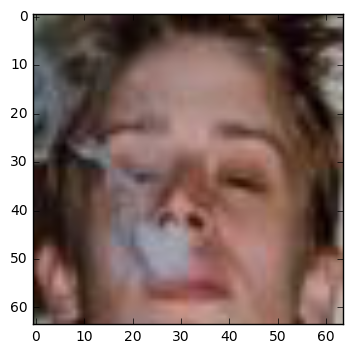

In [30]:
#get input image y
real_images=next(img_input)
batch_images = np.array(real_images).astype(np.float32)

img = (real_images[1,:,:,:] +1.)/2
plt.imshow(img)
plt.axis('on')
plt.show()

In [38]:
def create_mask(scale):
    m = np.ones(image_shape)
    l = int(image_size*scale)
    u = int(image_size*(1.0-scale))
    m[l:u, l:u, :] = 0.0
    return m
   
def random_mask(fract):
    fraction_masked = fract
    m = np.ones(image_shape)
    m[np.random.random(image_shape[:2]) < fraction_masked] = 0.0
    
def merge_images(image_batch, size):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im
    return img

#create the importance matrix
def create_imp_matrix():
    a=np.ones((64,64))
    n=64
    for k in range(1,16):
        for i in range(k,n-k):
            for j in range(k,n-k):
                a[i,j]+=1

    scale=0.25
    image_size=64
    sz = image_size
    l = int(image_size*scale)
    u = int(image_size*(1.0-scale))
    a[l:u, l:u] = 0.0

    non_zero_mean = np.sum(a)/(32*32)
    return a/32#non_zero_mean
    
def reshape_masks(m):
    return np.resize(m, [batch_size] + image_shape)

### Contexual Loss

We need to incorporate the information from the uncorrupted portion of the given image. The contextual loss is used to measure the context similarity between the reconstructed image and the uncorrupted portion, which is defined as 

\begin{align*}
L_{contexual}(z) = ||M \odot G(z) - M \odot y||_1
\end{align*}

where $M$ denotes the binary mask of the uncorruption and $\odot$ denotes the element-wise product operation. The corrupted portion is not used in the loss. The choice of $L1$ norm is empirical. 


### Perceptual Loss

The perceptual loss encourages the reconstructed image to be similar to the samples drawn from the training set. 
This is achieved by updating $z$ to fool $D$. As a result, $D$ will predict $G(z)$ to be from the data with a high probability. We use the same loss for fooling $D$ as in GAN:

\begin{align*}
L_{perceptual}(z) = log(1 - D(G(z))
\end{align*}

Without $L_{perceptual}$, the mapping from $x$ to $z$ can converge to a perceptually implausible result. Some reconstructed images tend to be unrealistic. 




In [39]:
#image completion
mask = tf.placeholder(tf.float32, [None] + image_shape, name='mask')
imp_matrix = tf.placeholder(tf.float32, [None] + image_shape, name='imp_matrix')

#define perceptual and contextual losses
perceptual_loss = gen_loss
contextual_loss = tf.reduce_sum(
    tf.contrib.layers.flatten(
        tf.multiply(tf.abs(tf.multiply(tf.cast(mask,tf.float32), tf.cast(G,tf.float32)) - tf.multiply(tf.cast(mask,tf.float32), tf.cast(images, tf.float32))),tf.cast(imp_matrix, tf.float32))), 1)

loss_ = contextual_loss + lambda_val*perceptual_loss
gradient_loss_ = tf.gradients(loss_, z)

maskType = 'center'
learning_r = 0.01

#get mask M
mask_ = create_mask(0.25)
importance_matrix = create_imp_matrix()
batch_mask = reshape_masks(mask_)
imp_mask = reshape_masks(importance_matrix)
z_hat_batch = np.random.uniform(-1, 1, size=(batch_size, 100))

#projected gradient descent
for i in xrange(5000):
    run = [loss_, gradient_loss_, G]
    loss, grad, G_imgs = sess.run(run, feed_dict={
        z: z_hat_batch,
        imp_matrix: imp_mask,
        mask: batch_mask,
        images: batch_images,
    })
    
    if (i%500 is 0):
        print "loss in iteration: " + str(i) + " is: " + str(np.mean(loss))
        
    z_hat_batch = np.clip(z_hat_batch - learning_r*grad[0], -1, 1)


loss in iteration: 0 is: 825.727
loss in iteration: 500 is: 250.502
loss in iteration: 1000 is: 255.339
loss in iteration: 1500 is: 264.981
loss in iteration: 2000 is: 265.09
loss in iteration: 2500 is: 258.692
loss in iteration: 3000 is: 253.039
loss in iteration: 3500 is: 254.474
loss in iteration: 4000 is: 254.169
loss in iteration: 4500 is: 250.957


In [40]:
np.mean(loss)

255.81247

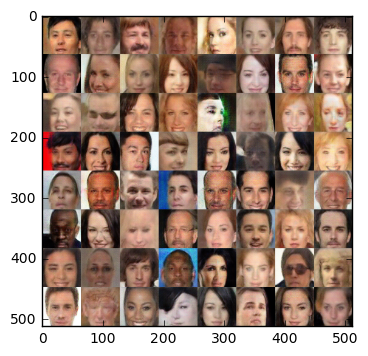

In [41]:
created_images = (G_imgs + 1.)/2
im = merge_images(created_images, [8,8])
plt.imshow(im)
plt.axis('on')
plt.show()

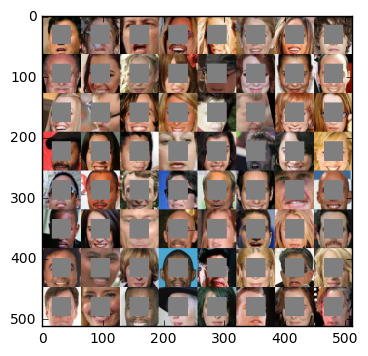

In [42]:
masked_images = np.multiply(batch_images, batch_mask)
input_images = (masked_images + 1.)/2
im = merge_images(input_images, [8,8])
plt.imshow(im)
plt.axis('on')
plt.show()

In [43]:
inv_mask_ = 1- mask_

In [ ]:
inv_batch_mask = np.resize(inv_mask_, [batch_size] + image_shape)
inv_masked_images = np.multiply(batch_images, inv_batch_mask)

inv_input_images = (inv_masked_images + 1.)/2
im_ = merge_images(inv_input_images, [8,8])
plt.imshow(im_)
plt.axis('on')
plt.show()

### Image Reconstruction

With the defined perceptual and contextual losses, the corrupted image can be mapped to the closest $z$ in the latent representation space. $z$ is updated using back-propagation with the total loss: 

\begin{align*}
\hat{z} = argmin_{z}L_{contexual}(z) + \lambda L_{perceptual}(z)
\end{align*}

where $\lambda$ is a weighting parameter. In practice, $\lambda$ has to be relatively small to constrain the recovered image with the input pixels. After finding $\hat{z}$, the inpainting can be obtained by: 

\begin{align*}
x_{reconstructed} = M \odot y + (1 - M) \odot G{(\hat{z})}
\end{align*}

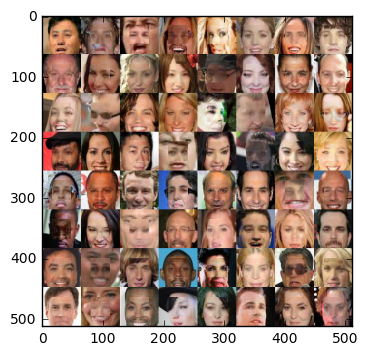

In [45]:
inv_batch_mask = np.resize(inv_mask_, [batch_size] + image_shape)
inv_masked_images = np.multiply(G_imgs, inv_batch_mask)

Recons_img = inv_masked_images + masked_images

rec_images = (Recons_img + 1.)/2
im_r = merge_images(rec_images, [8,8])
plt.imshow(im_r)
plt.axis('on')
plt.show()

<b> Completing our faces</b>
<img src='images/face_completion_us.jpg'>


<b> Image Completion on Flowerss</b>
<img src='images/flower_completion.jpg'>

<font size=6> <b> Contributions </b> </font>

<b><font size =6>References</font></b>
<ul>
<li> Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.</li>
<li> Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 2015.</li>
<li>Salimans, Tim, et al. "Improved techniques for training gans." Advances in Neural Information Processing Systems. 2016.</li>
<li>Yeh, Raymond, et al. "Semantic Image Inpainting with Perceptual and Contextual Losses." arXiv preprint arXiv:1607.07539 2016. </li>
<li> Chen, Xi, et al. "Infogan: Interpretable representation learning by information maximizing generative adversarial nets." Advances in Neural Information Processing Systems. 2016.</li>
<li>Denton, Emily L., Soumith Chintala, and Rob Fergus. "Deep Generative Image Models using a￼ Laplacian Pyramid of Adversarial Networks." Advances in neural information processing systems. 2015. </li>
<li> Ledig, Christian, et al. "Photo-realistic single image super-resolution using a generative adversarial network." arXiv preprint arXiv:1609.04802 (2016).</li>
<li> Reed, Scott E., et al. "Learning what and where to draw." Advances In Neural Information Processing Systems. 2016. </li>
<li> Isola, Phillip, et al. "Image-to-image translation with conditional adversarial networks." arXiv preprint arXiv:1611.07004 2016. </li>
<li> Zhang, Han, et al. "StackGAN: Text to Photo-realistic Image Synthesis with Stacked Generative Adversarial Networks." arXiv preprint arXiv:1612.03242 (2016). </li>
<li> Wang, Xiaolong, and Abhinav Gupta. "Generative image modeling using style and structure adversarial networks." European Conference on Computer Vision. Springer International Publishing, 2016.</li>
<li>Xie, Junyuan, Linli Xu, and Enhong Chen. "Image denoising and inpainting with deep neural networks." Advances in Neural Information Processing Systems. 2012.</li>
<li>Köhler, Rolf, et al. "Mask-specific inpainting with deep neural networks." German Conference on Pattern Recognition. Springer International Publishing, 2014.</li>
<li>Dosovitskiy, Alexey, and Thomas Brox. "Generating images with perceptual similarity metrics based on deep networks." Advances in Neural Information Processing Systems. 2016.</li>
<li> Sauer, Christopher, Russell Kaplan, and Alexander Lin. "Neural Fill: Content Aware Image Fill with Generative Adversarial Neural Networks." </li>
<li>http://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/</li>
<li>https://en.wikipedia.org/wiki/Generative_adversarial_networks</li>
<li> https://github.com/jacobgil/keras-dcgan </li>
<li> http://bamos.github.io/2016/08/09/deep-completion/ </li>
<li> https://github.com/soumith/dcgan.torch </li>
<li> https://github.com/carpedm20/DCGAN-tensorflow </li>
<li> https://github.com/rajathkumarmp/DCGAN </li>

</ul>
